In [ ]:
import random
from typing import TypedDict, List, Annotated
import operator
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from IPython.display import Image, display

**Data Processing**

In [2]:
class State(TypedDict):
    input: int
    partial: Annotated[List[int], operator.add]
    results: Annotated[List[int], operator.add]

In [3]:
def node_a(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['input'] + partial
    print(
        f"NODE A:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [4]:
def node_b(state: State, config: RunnableConfig):
    offset = 0
    if config:
        offset = config.get("configurable", {}).get("offset", 0)
    partial = random.randint(1,10) + offset
    output =  state['results'][-1] + partial
    print(
        f"NODE B:\n "
        f"->input:{output-partial}\n " 
        f"->offset:{offset}\n "
        f"->random:{partial-offset}\n "
        f"->partial:{partial}\n "
        f"->output:{output}\n "
    )
    return {"partial": [partial], "results": [output]}

In [5]:
workflow = StateGraph(State)

In [6]:
workflow.add_node(node_a)
workflow.add_node(node_b)

In [7]:
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

In [8]:
graph = workflow.compile()

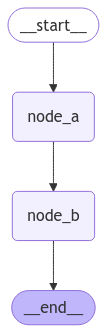

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png()
    )
)

In [10]:
config = {"configurable": {"offset": 10}}
graph.invoke(
    input = {
        "input": 1,
    }, 
    config = config,
)

NODE A:
 ->input:1
 ->offset:10
 ->random:2
 ->partial:12
 ->output:13
 
NODE B:
 ->input:13
 ->offset:10
 ->random:8
 ->partial:18
 ->output:31
 


{'input': 1, 'partial': [12, 18], 'results': [13, 31]}

**Call LLMs**

In [11]:
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.0,
)

In [12]:
class State(MessagesState):
    question:str

In [21]:
def model(state: State, config: RunnableConfig):
    question = state["question"]
    messages = state["messages"]
    name = None
    if config:
        name = config["configurable"].get("name")

    if name and not messages:
        messages.append(
            SystemMessage(
                "Help the following user. \n"
                f"Name={name} \n"
                "Give an initial greeting before responding."
            )
        )

    messages.append(HumanMessage(question))
    response = llm.invoke(messages)
    messages.append(response)

    return {"messages": messages}

In [22]:
workflow = StateGraph(State)

In [23]:
workflow.add_node("model", model)

In [24]:
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

In [25]:
graph = workflow.compile()

In [26]:
result = graph.invoke(
    input={"question": "What's the name of Ash's first pokémon?"}, 
    config={"configurable": {"name": "Henrique"}}
)

In [27]:
for message in result['messages']:
    message.pretty_print()

================================ System Message ================================

Help the following user. 
Name=Henrique 
Give an initial greeting before responding.
================================ Human Message =================================

What's the name of Ash's first pokémon?
================================== Ai Message ==================================

Hello, Henrique! Ash's first Pokémon is Pikachu. He received Pikachu from Professor Oak at the beginning of his journey in the Pokémon anime series. If you have any more questions about Pokémon or anything else, feel free to ask!
